## Steps

1. Sector = ('Industrials','Energy','Consumer Staples','Consumer Discretionery')
2. Multi class classification 
3. Not creating index, retaining date & cusip as is
4. Train & Test split without timeseries
5. Standardsclar 

Note- Model Performes better without timeseries split


# Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization

 # Load Data

In [2]:
#reading raw data
analystdata = pd.read_csv('Analyst_Data.csv')
financialratiodata = pd.read_csv('Financial_Ratios_Data.csv')
returnsdata = pd.read_excel('Returns_Data_V2.xlsx')


FileNotFoundError: [Errno 2] No such file or directory: 'Analyst_Data.csv'

In [ ]:
print("analystdata",analystdata.shape)
print("financialratiodata",financialratiodata.shape)
print("returnsdata",returnsdata.shape)

In [ ]:
## convert the column names to uppercase 

financialratiodata.columns = [col.upper() for col in financialratiodata.columns]
analystdata.columns = [col.upper() for col in analystdata.columns]
returnsdata.columns = [col.upper() for col in returnsdata.columns]



# Merge & filter the dataset

In [ ]:
# Financial_Ratios_Data & Returns_Data are merged on permno & date. 
# the datatype of Financial_Ratios_Data['date'] column is INT64. Returns_Data['date'] is datetime. 
# cast Financial_Ratios_Data['date'] to datetime & format both Financial_Ratios_Data['date'] & Returns_Data['date'] to 'YYYYMM' 

# filter Financial_Ratios_Data to select rows for Sector in ('Industrials','Energy')

Sector = ('Industrials','Energy','Consumer Staples','Consumer Discretionery')
#Sector = ('Industrials','Energy')

financialratiodata_filtered = financialratiodata[financialratiodata.SECTORNAME.isin(Sector)]
financialratiodata_filtered.shape

# # format financialratiodata_filtered['date'] 
financialratiodata_filtered['DATE'] = pd.to_datetime(financialratiodata_filtered['DATE'], format='%Y%m%d')
financialratiodata_filtered['DATE_YYYYMM'] = financialratiodata_filtered['DATE'].apply(lambda x: x.strftime('%Y%m')) 
#financialratiodata_filtered['date_YYYYMM']

# # format returnsdata['date'] 
returnsdata['DATE'] = pd.to_datetime(returnsdata['DATE'], format='%Y%m%d')
returnsdata['DATE_YYYYMM'] = returnsdata['DATE'].apply(lambda x: x.strftime('%Y%m')) 
#returnsdata['date_YYYYMM']



In [ ]:
# # merge Financial_Ratios_Data['date_YYYYMM'] & Returns_Data['date_YYYYMM']
#Merge1 = pd.merge(returnsdata, financialratiodata_filtered, left_on = ['PERMNO','date_YYYYMM'], right_on = ['permno','date_YYYYMM'], how ='inner')

#Merge1 = pd.merge(financialratiodata_filtered,returnsdata,  left_on = ['PERMNO','DATE_YYYYMM'], right_on = ['PERMNO','DATE_YYYYMM'], how ='left')

Merge1 = pd.merge(financialratiodata_filtered,returnsdata,  on = ['PERMNO','DATE_YYYYMM'], suffixes=('', '_drop'))


In [ ]:
# extract the rows for '2021-12-31', later this will be used for prediction
prediction_set = Merge1.loc[Merge1['DATE'] == '2021-12-31']
display(prediction_set)

In [3]:
# merge Analyst_data with Merge1

# Analyst_data is by mid of next month whereas financial & returns are by month end. hence transforming analystdata['date'] to set 15 days backwords to allign with financialratiodata & returnsdata.\

analystdata['STATPERS'] = pd.to_datetime(analystdata['STATPERS'], format='%Y%m%d')

# Shift the date column by 1 month backward
analystdata['STATPERS_backward'] = analystdata['STATPERS'] - pd.DateOffset(months=1)

analystdata['DATE_YYYYMM'] = analystdata['STATPERS_backward'].apply(lambda x: x.strftime('%Y%m')) 
#AD['STATPERS_mmyyyy']  


NameError: name 'analystdata' is not defined

In [4]:
# merge analystdata with Merge1

Final_merged_data = pd.merge(Merge1, analystdata, on = ['CUSIP','DATE_YYYYMM'], suffixes=('', '_drop') )
Final_merged_data.drop([col for col in Final_merged_data.columns if 'drop' in col], axis=1, inplace=True)


NameError: name 'Merge1' is not defined

In [5]:
## Total number of instances & features in final merged dataset 

print("Final_merged_data", Final_merged_data.shape)


NameError: name 'Final_merged_data' is not defined

## Deriving Target variable 

In [11]:
# # Sort the dataframe by CUSIP and date_x
Final_merged_data = Final_merged_data.sort_values(by=['CUSIP', 'DATE_YYYYMM'])

#Feature Engineering#
# Create a new column 'PCT_CHN' to capture 
Final_merged_data['PCT_CHN'] = 0

# Iterate over the rows of the dataframe
for i in range(1, len(Final_merged_data)):
# Check if the CUSIP code is the same as the previous row
    if Final_merged_data.loc[i, 'CUSIP'] == Final_merged_data.loc[i-1, 'CUSIP']:
# Calculate the percentage change between the current and previous row
        Final_merged_data.loc[i,'PCT_CHN'] = (Final_merged_data.loc[i, 'BUYPCT'] - Final_merged_data.loc[i-1, 'BUYPCT']) / Final_merged_data.loc[i-1, 'BUYPCT']
         

C:\Users\manch\AppData\Local\Temp\ipykernel_912\2037815472.py:13: RuntimeWarning: invalid value encountered in double_scalars
  Final_merged_data.loc[i,'PCT_CHN'] = (Final_merged_data.loc[i, 'BUYPCT'] - Final_merged_data.loc[i-1, 'BUYPCT']) / Final_merged_data.loc[i-1, 'BUYPCT']
C:\Users\manch\AppData\Local\Temp\ipykernel_912\2037815472.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  Final_merged_data.loc[i,'PCT_CHN'] = (Final_merged_data.loc[i, 'BUYPCT'] - Final_merged_data.loc[i-1, 'BUYPCT']) / Final_merged_data.loc[i-1, 'BUYPCT']


In [12]:

# Sort the dataframe by CUSIP and date_x
Final_merged_data = Final_merged_data.sort_values(by=['CUSIP', 'DATE_YYYYMM'])

# Create a new column 'Target' and set its initial value to 'NoChange'
Final_merged_data['Target'] = 'Drop'

# Iterate over the rows of the dataframe
for i in range(1, len(Final_merged_data)):
# Check if the CUSIP code is the same as the previous row
    if Final_merged_data.loc[i, 'CUSIP'] == Final_merged_data.loc[i-1, 'CUSIP']:
# Calculate the percentage change between the current and previous row
        pct_change = (Final_merged_data.loc[i, 'BUYPCT'] - Final_merged_data.loc[i-1, 'BUYPCT']) / Final_merged_data.loc[i-1, 'BUYPCT']
# Check if the percentage change is greater than 10%
    if pct_change > 0.01 and Final_merged_data.loc[i, 'BUYPCT'] !=0 and Final_merged_data.loc[i-1, 'BUYPCT'] !=0:
        Final_merged_data.loc[i, 'Target'] = 'Upgrade'
# Check if the percentage change is less than -10%
    elif pct_change <= -0.01 and Final_merged_data.loc[i, 'BUYPCT'] !=0 and Final_merged_data.loc[i-1, 'BUYPCT'] !=0:
        Final_merged_data.loc[i, 'Target'] = 'Downgrade'
    elif pct_change == 0: 
        Final_merged_data.loc[i, 'Target'] = 'NoChange'
    else:    
        Final_merged_data.loc[i, 'Target'] = 'Drop'  

C:\Users\manch\AppData\Local\Temp\ipykernel_912\3494948780.py:12: RuntimeWarning: invalid value encountered in double_scalars
  pct_change = (Final_merged_data.loc[i, 'BUYPCT'] - Final_merged_data.loc[i-1, 'BUYPCT']) / Final_merged_data.loc[i-1, 'BUYPCT']
C:\Users\manch\AppData\Local\Temp\ipykernel_912\3494948780.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  pct_change = (Final_merged_data.loc[i, 'BUYPCT'] - Final_merged_data.loc[i-1, 'BUYPCT']) / Final_merged_data.loc[i-1, 'BUYPCT']


In [13]:

# # Sort the dataframe by CUSIP and date_x
# Final_merged_data = Final_merged_data.sort_values(by=['CUSIP', 'DATE_YYYYMM'])

# # Create a new column 'Target' and set its initial value to 'NoChange'
# Final_merged_data['Target'] = 'Drop'
# Final_merged_data['pct_change'] = 0

# # Iterate over the rows of the dataframe
# for i in range(1, len(Final_merged_data)):
# # Check if the CUSIP code is the same as the previous row
#     if Final_merged_data.loc[i, 'CUSIP'] == Final_merged_data.loc[i-1, 'CUSIP']:
# # Calculate the percentage change between the current and previous row
#         Final_merged_data[i, 'pct_change'] = (Final_merged_data.loc[i, 'BUYPCT'] - Final_merged_data.loc[i-1, 'BUYPCT']) / Final_merged_data.loc[i-1, 'BUYPCT']
# # Check if the percentage change is greater than 10%
#     if Final_merged_data[i, 'pct_change'] > 0.01 and Final_merged_data.loc[i, 'BUYPCT'] !=0 and Final_merged_data.loc[i-1, 'BUYPCT'] !=0:
#         Final_merged_data.loc[i, 'Target'] = 'Upgrade'
# # Check if the percentage change is less than -10%
#     elif Final_merged_data[i, 'pct_change'] <= -0.01 and Final_merged_data.loc[i, 'BUYPCT'] !=0 and Final_merged_data.loc[i-1, 'BUYPCT'] !=0:
#         Final_merged_data.loc[i, 'Target'] = 'Downgrade'
#     elif Final_merged_data[i, 'pct_change'] == 0: 
#         Final_merged_data.loc[i, 'Target'] = 'NoChange'
#     else:    
#         Final_merged_data.loc[i, 'Target'] = 'Drop'  

In [14]:
# ## detect the missing values

# ColumnNames_missingValues = Final_merged_data.loc[:,list(Final_merged_data.loc[:,Final_merged_data.isnull().any()].columns)].isnull().sum()/(len(Final_merged_data))*100

# # Write DataFrame to a CSV file with the new column names
# new_columns = [ 'Percentage']
# ColumnNames_missingValues.columns = new_columns

# ColumnNames_missingValues.to_csv('ColumnNames_missingValues.csv',  header=new_columns) 


In [15]:
## Approach 1 drop instances with missing values
Final_merged_data = Final_merged_data.dropna()

# Final_merged_data.shape

In [16]:
# drop the instances for which target value was unable to derive 
Final_merged_data = Final_merged_data[ ~(Final_merged_data['Target'] == 'Drop')]


### Correlation between PCT_CHN & Cusip Features

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Selected_feat = ['PRICE_EARNING','EVM','PRICE_TO_BOOK','PRICE_SALE','GROSS_PROFIT','CAPEI','BOOK_MARKET','FRWD_1M_RET','FRWD_3M_RET','PAST 36M VOLATILITY' ,'BUYPCT' ]

Final_merged_data_feat = Final_merged_data[Selected_feat]
Final_merged_data_feat.head()

corr = Final_merged_data_feat.corr()
#sns.heatmap(corr, annot=True, cmap='green')
#plt.show()



In [18]:
# Fill diagonal and upper half with NaNs
#mask[np.triu_indices_from(mask)] = True

(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\manch\AppData\Local\Temp\ipykernel_912\44156803.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


,PRICE_EARNING,EVM,PRICE_TO_BOOK,PRICE_SALE,GROSS_PROFIT,CAPEI,BOOK_MARKET,FRWD_1M_RET,FRWD_3M_RET,PAST 36M VOLATILITY,BUYPCT
PRICE_EARNING,1.00,0.15,0.08,0.14,0.07,0.14,-0.13,-0.01,-0.03,-0.09,0.01
EVM,0.15,1.00,0.19,0.41,0.10,0.21,-0.33,0.02,0.04,-0.27,0.03
PRICE_TO_BOOK,0.08,0.19,1.00,0.21,0.19,0.11,-0.48,0.01,0.02,-0.27,-0.11
PRICE_SALE,0.14,0.41,0.21,1.00,0.00,0.35,-0.40,0.01,0.03,-0.32,-0.07
GROSS_PROFIT,0.07,0.10,0.19,0.00,1.00,0.09,-0.39,-0.04,-0.05,-0.08,-0.15
CAPEI,0.14,0.21,0.11,0.35,0.09,1.00,-0.23,-0.04,-0.06,-0.21,0.07
BOOK_MARKET,-0.13,-0.33,-0.48,-0.40,-0.39,-0.23,1.00,-0.03,-0.06,0.48,0.11
FRWD_1M_RET,-0.01,0.02,0.01,0.01,-0.04,-0.04,-0.03,1.00,0.58,0.02,0.02
FRWD_3M_RET,-0.03,0.04,0.02,0.03,-0.05,-0.06,-0.06,0.58,1.00,0.01,-0.01
PAST 36M VOLATILITY,-0.09,-0.27,-0.27,-0.32,-0.08,-0.21,0.48,0.02,0.01,1.00,0.01


<AxesSubplot:>

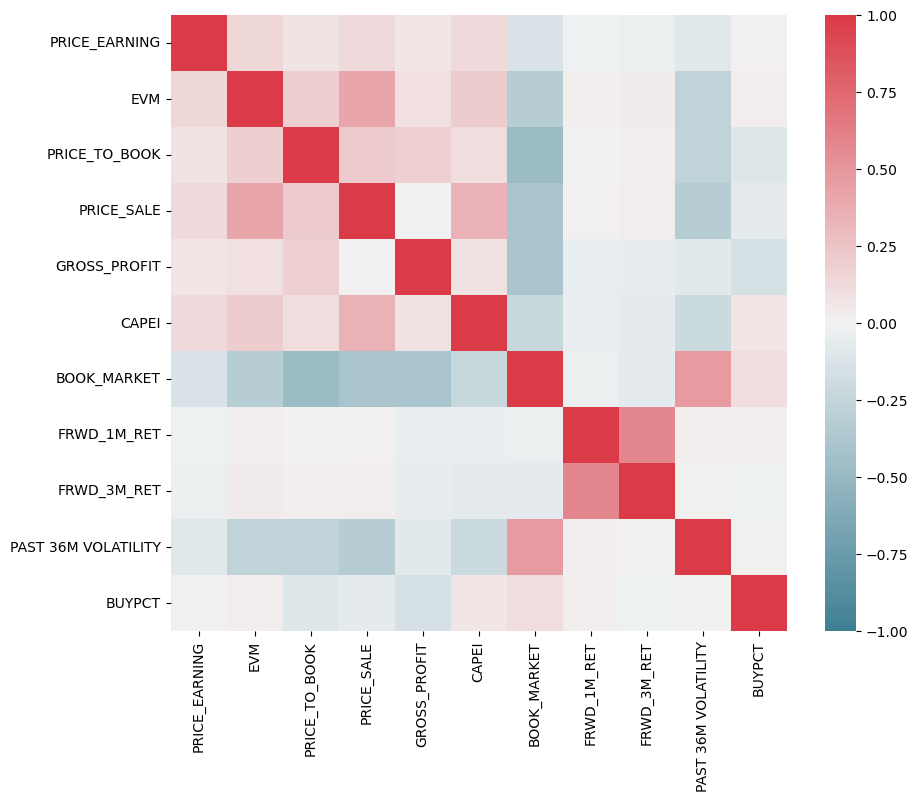

In [19]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

In [ ]:
import seaborn as sns
import pandas as pd

# Create the pair plot with some customizations
sns.pairplot(Final_merged_data, hue="BUYPCT", palette="husl", markers=["o", "s", "D"])

In [20]:
Final_merged_data.to_csv("C:/Personal/1 MMA/1 MMA 823 Analytics for Financial Markets/Team Projects/DataSet/Intermedietery_Files/Final_merged_data_BUYPCT.csv", index = False)

In [21]:
Final_merged_data.shape

(4189, 107)

In [22]:
# drop repetative columns from Final_merged_data
drop = ['CUSIP','GVKEY', 'PCT_CHN',
'PERMNO',
'TICKER',
#'DATE',
'CUSIPDATE',
'COMNAM',
'YEAR',
'MONTH',
'OFTIC',
'CNAME',
'STATPERS',
'MEANREC',
'MEDREC',
'STDEV',
'NUMREC',
'NUMUP',
'NUMDOWN',
'BUYPCT',
'SELLPCT',
'HOLDPCT',
'STATPERS_backward']

Final_merged_data = Final_merged_data.drop(drop,axis = 1)



KeyError: "['CUSIPDATE'] not found in axis"

In [ ]:
# Final_merged_data = Final_merged_data.dropna()
# Final_merged_data.shape

In [ ]:
# explore target value distribution

print(Final_merged_data['Target'].value_counts())

In [ ]:
# Final_merged_data['CusipDate'] = Final_merged_data['CUSIP'] + Final_merged_data['DATE_YYYYMM']

# Final_merged_data.to_csv("C:/Personal/1 MMA/1 MMA 823 Analytics for Financial Markets/Team Projects/DataSet/Updated/Final_merged_data_INDEX.csv", index =False)


In [ ]:
# Final_merged_data = pd.read_csv("C:/Personal/1 MMA/1 MMA 823 Analytics for Financial Markets/Team Projects/DataSet/Updated/Final_merged_data_INDEX.csv", index_col='CusipDate')

In [ ]:
Final_merged_data['MONTH_RETURN'] = Final_merged_data['MONTH_RETURN'].astype(float)
#Final_merged_data['Month_Return'] = Final_merged_data['Month_Return'].astype(float)

In [ ]:
# drop repetative columns 
drop_val = ['CUSIP','GVKEY',
'PERMNO',
'TICKER',
'DATE',
'CUSIPDATE',
'COMNAM',
'YEAR',
'MONTH']

prediction_set = prediction_set.drop(drop_val, axis = 1)


In [ ]:

X1 = Final_merged_data.drop('Target', axis=1)
Y1 = Final_merged_data['Target']



In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# tss = TimeSeriesSplit(n_splits = 3)

# # # Final_merged_data.set_index('DATE', inplace=True)
# # # Final_merged_data.sort_index(inplace=True)

# # #display(Final_merged_data)

# # for train_index, test_index in tss.split(X1):
# #     X_train, X_test = X1.iloc[train_index, :], X1.iloc[test_index,:]
# #     y_train, y_test = Y1.iloc[train_index], Y1.iloc[test_index]
    

# # date_column = X1['DATE']

# # # Split the data based on the date column
# # mask1 =  (date_column < '2019-06-01')
# # X_train = X1.loc[mask1]



# # mask2 = (date_column >= '2019-06-30') & (date_column < '2022-11-30')
# # X_test = X1.loc[mask2]
    
    

In [ ]:
# y_train = Y1.loc[mask1]
# y_test = Y1.loc[mask2]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.6, random_state=42)

In [ ]:
print("X_train Max date", X_train['DATE'].max())
print("X_test Max date", X_test['DATE'].max())

print("X_train min date", X_train['DATE'].min())
print("X_test min date", X_test['DATE'].min())

In [ ]:
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape) 

# X_train.to_csv("C:/Personal/1 MMA/1 MMA 823 Analytics for Financial Markets/Team Projects/DataSet/InputData/X_train.csv", index =True)
# X_test.to_csv("C:/Personal/1 MMA/1 MMA 823 Analytics for Financial Markets/Team Projects/DataSet/InputData/X_test.csv", index =True)

# y_train.to_csv("C:/Personal/1 MMA/1 MMA 823 Analytics for Financial Markets/Team Projects/DataSet/InputData/y_train.csv", index =True)
# y_test.to_csv("C:/Personal/1 MMA/1 MMA 823 Analytics for Financial Markets/Team Projects/DataSet/InputData/y_test.csv", index =True)



In [ ]:
y_test.to_csv("C:/Personal/1 MMA/1 MMA 823 Analytics for Financial Markets/Team Projects/DataSet/Prediction/y_test1.csv")

In [ ]:
# dnt run
# cat_cols = list(Final_merged_data.select_dtypes(include='object'))
float_cols = list(Final_merged_data.select_dtypes(include='float64'))

# cat_cols, float_cols


In [ ]:
from sklearn.preprocessing import StandardScaler

import pandas as pd

def normalize_groupby(df, group_col, feature_cols):
    # Create a StandardScaler object
    scaler = StandardScaler()
    
    # Group the data by the specified column
    grouped = df.groupby(group_col)
    
    # Iterate over each group
    for name, group in grouped:
        # Fit the StandardScaler object to the group
        scaler.fit(group[feature_cols].values)
        # Transform the group using the fitted StandardScaler object
        group_scaled = scaler.transform(group[feature_cols].values)
        # Assign the scaled group back to the original DataFrame
        df.loc[group.index, feature_cols] = group_scaled
        
    return df

# define the input variables
df = X_train
group_col = "DATE_YYYYMM"
feature_cols = float_cols

df_normalized = normalize_groupby(df, group_col, feature_cols)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import optuna
from optuna.samplers import TPESampler

In [ ]:
cat_cols = ['SECTORNAME']

float_cols = list(X_train.select_dtypes(include='float64'))

X_train[cat_cols] = X_train[cat_cols].astype('category')

X_test[cat_cols] = X_test[cat_cols].astype('category')


drop_features = ['DATE','DATE_YYYYMM']


X_train = X_train.drop(drop_features, axis = 1)
X_test = X_test.drop(drop_features, axis = 1)


# # #X_train = X_train.drop('DATE_YYYYMM', axis=1)
# # X_train = X_train.drop('DATE', axis=1)


# # #X_test = X_test.drop('DATE_YYYYMM', axis=1)
# # X_test = X_test.drop('DATE', axis=1)



In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())
    

In [ ]:
# class_counts = np.bincount(y_train)

# y_test.value_counts()

# # Calculate the weight for each class
# class_weights = class_counts.max() / class_counts

# # Convert the class weights to a dictionary
# class_weight_dict = dict(enumerate(class_weights))

# # Train a LightGBM classifier with the custom class weights
# lgb_model = lgb.LGBMClassifier(class_weight=class_weight_dict)
# lgb_model.fit(X_train, y_train)

In [ ]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        #"verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 3,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 0.0001, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 0.001, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 150),
        #new setting 
        'verbose': trial.suggest_int('verbose', -2, 10), 
        'max_bin': trial.suggest_int('max_bin', 80, 2000),
        'class_weight':'balanced'
    }
    gbm = lgb.LGBMClassifier(**param)

    # you can put this back if you want to use holdout method
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    F1 = f1_score(y_test, preds,average='micro')
    return F1

    # this is the line i added for CV, but not sure if its correct
#     scores = cross_val_score(gbm, X, y, cv = 3,scoring='f1_micro' )
#     goal = scores.mean()
#     return goal

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=30) ## < change this 500 to 1000 once you are ready to find the best combo, but it takes hours to run.


In [ ]:
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X_train, y_train)

y_pred=model.predict(X_test)


In [ ]:
print(classification_report(y_test, y_pred))
print("Best_Score - RF", model.score)
print("best_params - RF", model.get_params())


# print("cv_scores_clf_b",cv_scores_clf_b)
# print("------------------------------------------------------------------------")
# print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(cv_scores_clf_b), np.std(cv_scores_clf_b)))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [ ]:
from sklearn import metrics

# confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
# cm_display.plot()
# plt.show()

cm = metrics.confusion_matrix(y_test, y_pred)

cm_obj = metrics.ConfusionMatrixDisplay(cm, display_labels = ['Downgrade', 'NoChange', 'Upgrade'])
cm_obj.plot()

cm_obj.ax_.set(title= 'SKlearn Confusion Matrix with Labels', 
                xlabel = 'Predcted Values', 
                ylabel = 'Actual Values')
plt.show()
